<a href="https://colab.research.google.com/github/omarabushanab/FPL-Predictive-Model/blob/main/Untitled58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv("..\\data\\cleaned_merged_seasons.csv")

C:\Users\melsa\AppData\Local\Temp\ipykernel_31476\2390463826.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("..\\data\\cleaned_merged_seasons.csv")


In [31]:
df.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [32]:
df['team_x'].value_counts()

team_x
Everton           4079
Brighton          4026
Arsenal           3998
Aston Villa       3990
Wolves            3952
Leeds             3866
Man Utd           3853
Liverpool         3838
Spurs             3746
Crystal Palace    3679
Newcastle         3646
Chelsea           3646
Southampton       3627
Leicester         3567
Man City          3529
West Ham          3380
Fulham            2710
Brentford         2629
Burnley           2279
Watford           1678
Nott'm Forest     1645
Bournemouth       1339
Norwich           1295
West Brom         1212
Sheffield Utd     1108
Name: count, dtype: int64

# Data Cleaning


In [33]:
df = df.drop(columns=['transfers_out'])


In [34]:
df = df.drop(columns=['transfers_in'])

In [35]:
df = df.drop(columns=['selected'])

In [36]:
df["position"] = df["position"].replace("GKP", "GK")

In [37]:
print(df.columns)

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')


# Form column creation


In [5]:

# Make sure gameweeks are sorted properly
df = df.sort_values(["season_x", "element", "GW"])

# Group by player & season, then calculate rolling average of total_points
df["form"] = (
    df.groupby(["season_x", "element"])["total_points"]
      .transform(lambda x: x.rolling(window=4, min_periods=1).mean() / 10)
)


In [39]:
df.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance', 'value',
       'was_home', 'yellow_cards', 'GW', 'form'],
      dtype='object')

# Team data augmenting "SEIF"

In [ ]:
print(df["total_points"].unique())

[ 0  9  2 11  6  4  7  1  8  5  3 13 10 14 12 -1 15 21 18 17 16 -2 19 20
 24 -3 29 -7 -4 22 23]


In [ ]:
import pandas as pd

# Ranking before GW1
pl_table_2016_17 = {
    1: "Arsenal",
    2: "Bournemouth",
    3: "Burnley",
    4: "Chelsea",
    5: "Crystal Palace",
    6: "Everton",
    7: "Hull City",
    8: "Leicester City",
    9: "Liverpool",
    10: "Manchester City",
    11: "Manchester United",
    12: "Middlesbrough",
    13: "Southampton",
    14: "Stoke City",
    15: "Sunderland",
    16: "Swansea City",
    17: "Tottenham Hotspur",
    18: "Watford",
    19: "West Bromwich Albion",
    20: "West Ham United"
}

# Gameweek 1 fixtures (two-way mapping)
fixture_lookup = {
    "Arsenal": "Liverpool",
    "Liverpool": "Arsenal",
    "Bournemouth": "Manchester United",
    "Manchester United": "Bournemouth",
    "Burnley": "Swansea City",
    "Swansea City": "Burnley",
    "Chelsea": "West Ham United",
    "West Ham United": "Chelsea",
    "Crystal Palace": "West Bromwich Albion",
    "West Bromwich Albion": "Crystal Palace",
    "Everton": "Tottenham Hotspur",
    "Tottenham Hotspur": "Everton",
    "Hull City": "Leicester City",
    "Leicester City": "Hull City",
    "Manchester City": "Sunderland",
    "Sunderland": "Manchester City",
    "Middlesbrough": "Stoke City",
    "Stoke City": "Middlesbrough",
    "Southampton": "Watford",
    "Watford": "Southampton"
}

# Fill function for team_x
def fill_team_x(row):
    if (
        row["season_x"] == "2016-17"
        and row["GW"] == 1
        and pd.isna(row["team_x"])
    ):
        opp_name = row["opp_team_name"]
        opp_pos = row["opponent_team"]

        # If opponent name not in lookup, derive it using position
        if pd.notna(opp_pos) and opp_name not in fixture_lookup:
            try:
                opp_pos = int(opp_pos)
                opp_name = pl_table_2016_17.get(opp_pos, opp_name)
            except ValueError:
                pass

        # Return the team that faced this opponent
        return fixture_lookup.get(opp_name, row["team_x"])

    return row["team_x"]

# Apply the fill logic to each row
df["team_x"] = df.apply(fill_team_x, axis=1)

# Save output
df.to_csv("filled_teamx_gw1_2016_17.csv", index=False)


In [ ]:
import pandas as pd

# --- Premier League 2017–18 clubs ---
pl_table_2017_18 = {
    1: "Arsenal",
    2: "Bournemouth",
    3: "Brighton & Hove Albion",
    4: "Burnley",
    5: "Chelsea",
    6: "Crystal Palace",
    7: "Everton",
    8: "Huddersfield Town",
    9: "Leicester City",
    10: "Liverpool",
    11: "Manchester City",
    12: "Manchester United",
    13: "Newcastle United",
    14: "Southampton",
    15: "Stoke City",
    16: "Swansea City",
    17: "Tottenham Hotspur",
    18: "Watford",
    19: "West Bromwich Albion",
    20: "West Ham United"
}

# --- Actual GW1 fixtures (2017–18) two-way mapping ---
fixture_lookup_2017_18 = {
    "Arsenal": "Leicester City",
    "Leicester City": "Arsenal",
    "Brighton & Hove Albion": "Manchester City",
    "Manchester City": "Brighton & Hove Albion",
    "Chelsea": "Burnley",
    "Burnley": "Chelsea",
    "Crystal Palace": "Huddersfield Town",
    "Huddersfield Town": "Crystal Palace",
    "Everton": "Stoke City",
    "Stoke City": "Everton",
    "Manchester United": "West Ham United",
    "West Ham United": "Manchester United",
    "Newcastle United": "Tottenham Hotspur",
    "Tottenham Hotspur": "Newcastle United",
    "Southampton": "Swansea City",
    "Swansea City": "Southampton",
    "Watford": "Liverpool",
    "Liverpool": "Watford",
    "West Bromwich Albion": "Bournemouth",
    "Bournemouth": "West Bromwich Albion"
}

# --- Fill team_x function for GW1 ---
def fill_team_x2(row):
    if (
        row["season_x"] == "2017-18"  # updated season
        and row["GW"] == 1
        and pd.isna(row["team_x"])
    ):
        opp_name = row["opp_team_name"]
        opp_pos = row["opponent_team"]

        # If opponent name not in lookup, derive using position
        if pd.notna(opp_pos) and opp_name not in fixture_lookup_2017_18:
            try:
                opp_pos = int(opp_pos)
                opp_name = pl_table_2017_18.get(opp_pos, opp_name)
            except ValueError:
                pass

        # Return the team that faced this opponent
        return fixture_lookup_2017_18.get(opp_name, row["team_x"])

    return row["team_x"]


# --- Apply the fill logic ---
df["team_x"] = df.apply(fill_team_x2, axis=1)

# --- Save updated dataframe ---
df.to_csv("filled_teamx_gw1_2017_18.csv", index=False)
print("✅ team_x filled for GW1 2017–18 and saved successfully.")


✅ team_x filled for GW1 2017–18 and saved successfully.


In [ ]:
df = pd.read_csv("/content/filled_teamx_gw1_2016_17.csv")

In [ ]:
df.head()

,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,...,team_a_score,team_h_score,threat,total_points,transfers_balance,value,was_home,yellow_cards,GW,form
0,2016-17,Héctor Bellerín,DEF,Arsenal,0,0,9,0,6.8,6,...,4.0,3.0,2.0,0,0,65,True,0,1,0.000000
1,2016-17,Héctor Bellerín,DEF,NaN,0,3,31,1,28.9,6,...,0.0,0.0,11.0,9,-56304,65,False,0,2,0.450000
2,2016-17,Héctor Bellerín,DEF,NaN,0,0,16,0,20.4,6,...,3.0,1.0,8.0,2,-14824,65,False,0,3,0.366667
3,2016-17,Héctor Bellerín,DEF,NaN,0,0,15,0,5.5,6,...,1.0,2.0,10.0,2,-22447,65,True,0,4,0.325000
4,2016-17,Héctor Bellerín,DEF,NaN,0,0,13,0,22.3,6,...,4.0,1.0,4.0,2,-34253,65,False,0,5,0.375000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76512 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [ ]:
liverpool_players = df[
    (df["season_x"] == "2016-17") &
    (df["GW"] == 20) &
    (df["team_x"] == "Liverpool")
]

print(liverpool_players)

liverpool_players.info()

Empty DataFrame
Columns: [season_x, name, position, team_x, assists, bonus, bps, clean_sheets, creativity, element, fixture, goals_conceded, goals_scored, ict_index, influence, kickoff_time, minutes, opponent_team, opp_team_name, own_goals, penalties_missed, penalties_saved, red_cards, round, saves, team_a_score, team_h_score, threat, total_points, transfers_balance, value, was_home, yellow_cards, GW, form]
Index: []

[0 rows x 35 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           0 non-null      object 
 1   name               0 non-null      object 
 2   position           0 non-null      object 
 3   team_x             0 non-null      object 
 4   assists            0 non-null      int64  
 5   bonus              0 non-null      int64  
 6   bps                0 non-null      int64  
 7   clean_sheets       0 non-null  

In [ ]:
Arsenal_players = df[
    (df["season_x"] == "2016-17") &
    (df["GW"] == 24) &
    (df["team_x"] == "Arsenal")
]

print(Arsenal_players)

Arsenal_players.value_counts()


Empty DataFrame
Columns: [season_x, name, position, team_x, assists, bonus, bps, clean_sheets, creativity, element, fixture, goals_conceded, goals_scored, ict_index, influence, kickoff_time, minutes, opponent_team, opp_team_name, own_goals, penalties_missed, penalties_saved, red_cards, round, saves, team_a_score, team_h_score, threat, total_points, transfers_balance, value, was_home, yellow_cards, GW, form]
Index: []

[0 rows x 35 columns]


,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,count
season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,team_a_score,team_h_score,threat,total_points,transfers_balance,value,was_home,yellow_cards,GW,form,


In [ ]:
# First, create a lookup (player → team) from GW1 of 2016/2017
gw1_team_lookup = (
    df[
        (df["season_x"] == "2016-17") &
        (df["GW"] == 1)
    ][["name", "team_x"]]
    .dropna()
    .drop_duplicates(subset=["name"])
    .set_index("name")["team_x"]
    .to_dict()
)

# Now, fill missing team_x for 2016/2017 using that mapping
def fill_team_from_gw1(row):
    if (
        row["season_x"] == "2016-17" and
        pd.isna(row["team_x"])
    ):
        return gw1_team_lookup.get(row["name"], row["team_x"])
    return row["team_x"]

df["team_x"] = df.apply(fill_team_from_gw1, axis=1)

# Save updated dataset
df.to_csv("filled_teamx_all_gw_2016_17.csv", index=False)


In [ ]:
import pandas as pd

# Sort by season and gameweek to ensure sequential filling
df = df.sort_values(["season_x", "GW"]).reset_index(drop=True)

# Focus on 2016/2017 (you can loop over all seasons later)
season_mask = df["season_x"] == "2016-17"
season_df = df[season_mask].copy()

# Iterate over GWs sequentially
for gw in sorted(season_df["GW"].unique()):
    gw_mask = (season_df["GW"] == gw)

    # Separate known and unknown teams in this GW
    known = season_df[gw_mask & season_df["team_x"].notna()]
    unknown = season_df[gw_mask & season_df["team_x"].isna()]

    # Build mapping: opponent → known team
    opp_to_team = (
        known.groupby("opp_team_name")["team_x"]
        .first()
        .to_dict()
    )

    # Now, for each unknown player, fill if their opp_team_name appears in the mapping
    season_df.loc[gw_mask & season_df["team_x"].isna(), "team_x"] = (
        season_df.loc[gw_mask & season_df["team_x"].isna(), "opp_team_name"]
        .map(opp_to_team)
    )

# Update the main df with filled values
df.loc[season_mask, "team_x"] = season_df["team_x"]

# Save output
df.to_csv("filled_teamx_sequential_gw_2016_17.csv", index=False)


In [ ]:
# First, create a lookup (player → team) from GW1 of 2016/2017
gw1_team_lookup = (
    df[
        (df["season_x"] == "2017-18") &
        (df["GW"] == 1)
    ][["name", "team_x"]]
    .dropna()
    .drop_duplicates(subset=["name"])
    .set_index("name")["team_x"]
    .to_dict()
)

# Now, fill missing team_x for 2016/2017 using that mapping
def fill_team_from_gw1(row):
    if (
        row["season_x"] == "2017-18" and
        pd.isna(row["team_x"])
    ):
        return gw1_team_lookup.get(row["name"], row["team_x"])
    return row["team_x"]

df["team_x"] = df.apply(fill_team_from_gw1, axis=1)

# Save updated dataset
df.to_csv("filled_teamx_all_gw_2017_18.csv", index=False)

In [ ]:
import pandas as pd

# Sort by season and gameweek to ensure sequential filling
df = df.sort_values(["season_x", "GW"]).reset_index(drop=True)

# Focus on 2016/2017 (you can loop over all seasons later)
season_mask = df["season_x"] == "2017-18"
season_df = df[season_mask].copy()

# Iterate over GWs sequentially
for gw in sorted(season_df["GW"].unique()):
    gw_mask = (season_df["GW"] == gw)

    # Separate known and unknown teams in this GW
    known = season_df[gw_mask & season_df["team_x"].notna()]
    unknown = season_df[gw_mask & season_df["team_x"].isna()]

    # Build mapping: opponent → known team
    opp_to_team = (
        known.groupby("opp_team_name")["team_x"]
        .first()
        .to_dict()
    )

    # Now, for each unknown player, fill if their opp_team_name appears in the mapping
    season_df.loc[gw_mask & season_df["team_x"].isna(), "team_x"] = (
        season_df.loc[gw_mask & season_df["team_x"].isna(), "opp_team_name"]
        .map(opp_to_team)
    )

# Update the main df with filled values
df.loc[season_mask, "team_x"] = season_df["team_x"]

# Save output
df.to_csv("filled_teamx_sequential_gw_2017_18.csv", index=False)


In [ ]:
null_counts_per_gw = (
    df[df["season_x"] == "2016-17"]
    .groupby("GW")["team_x"]
    .apply(lambda x: x.isna().sum())
    .reset_index(name="null_count")
    .sort_values("GW")
)

print(null_counts_per_gw)

    GW  null_count
0    1           0
1    2           0
2    3           0
3    4           0
4    5           0
5    6           0
6    7           0
7    8           0
8    9           0
9   10           0
10  11           0
11  12           0
12  13           0
13  14           0
14  15           0
15  16           0
16  17           0
17  18           0
18  19           0
19  20           0
20  21           0
21  22           0
22  23           0
23  24           0
24  25           0
25  26           0
26  27           0
27  28           0
28  29           0
29  30           0
30  31           0
31  32           0
32  33           0
33  34           0
34  35           0
35  36           0
36  37           0
37  38           0


In [ ]:
# Count null team_x for each Gameweek in 2016/2017
null_counts_per_gw = (
    df[df["season_x"] == "2017-18"]
    .groupby("GW")["team_x"]
    .apply(lambda x: x.isna().sum())
    .reset_index(name="null_count")
    .sort_values("GW")
)

print(null_counts_per_gw)


    GW  null_count
0    1         270
1    2         270
2    3         275
3    4         279
4    5         280
5    6         282
6    7         284
7    8         284
8    9         286
9   10         288
10  11         289
11  12         290
12  13         290
13  14         291
14  15         293
15  16         293
16  17         294
17  18         295
18  19         297
19  20         297
20  21         258
21  22         336
22  23         301
23  24         302
24  25         304
25  26         309
26  27         309
27  28         309
28  29         310
29  30         311
30  31         104
31  32         312
32  33         313
33  34         446
34  35         192
35  36         314
36  37         513
37  38         315


### 2a Visualization

Sample of season-position summed points:


,season_x,position,season_position_total_points
0,2016-17,DEF,5536
1,2016-17,FWD,3180
2,2016-17,GK,1720
3,2016-17,MID,6493
4,2017-18,DEF,7018
5,2017-18,FWD,3462
6,2017-18,GK,2220
7,2017-18,MID,8428
8,2020-21,DEF,10461
9,2020-21,FWD,4538



Average summed points per position (averaged across seasons):


,position,avg_sum_points_across_seasons
0,MID,11384.4
1,DEF,8705.2
2,FWD,3975.8
3,GK,2463.2



As percentages of average total points (across seasons):


,position,avg_sum_points_across_seasons,pct_of_total
0,MID,11384.4,42.913686
1,DEF,8705.2,32.814397
2,FWD,3975.8,14.986844
3,GK,2463.2,9.285073


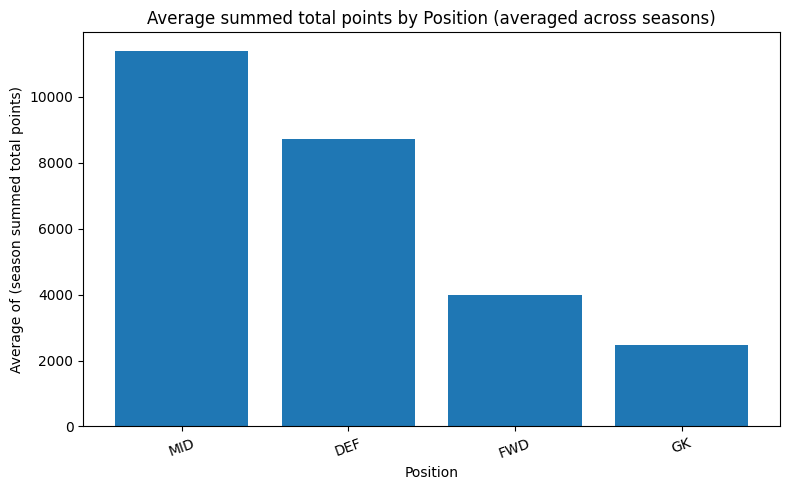

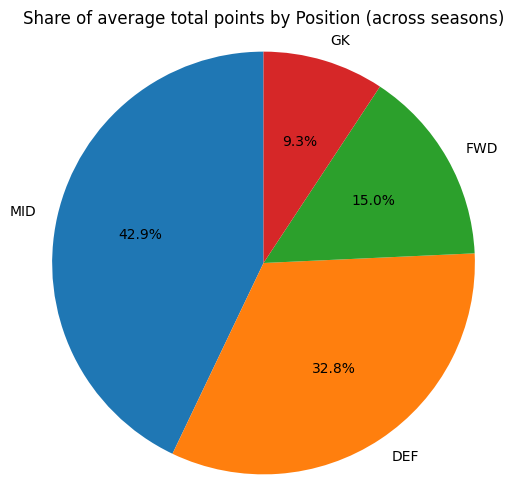

In [19]:

season_position_sum = (
    df.groupby(['season_x', 'position'], dropna=False)['total_points']
      .sum()
      .reset_index()
      .rename(columns={'total_points': 'season_position_total_points'})
)

print("Sample of season-position summed points:")
display(season_position_sum.head(12))

# === Step 2: Average of seasonal sums across seasons (the requested metric) ===
avg_season_sum_by_position = (
    season_position_sum.groupby('position')['season_position_total_points']
      .mean()
      .reset_index()
      .rename(columns={'season_position_total_points': 'avg_sum_points_across_seasons'})
      .sort_values('avg_sum_points_across_seasons', ascending=False)
      .reset_index(drop=True)
)

print("\nAverage summed points per position (averaged across seasons):")
display(avg_season_sum_by_position)

# === Step 3: Add percentage of total (for easy interpretation) ===
total_avg = avg_season_sum_by_position['avg_sum_points_across_seasons'].sum()
avg_season_sum_by_position['pct_of_total'] = 100 * avg_season_sum_by_position['avg_sum_points_across_seasons'] / total_avg
print("\nAs percentages of average total points (across seasons):")
display(avg_season_sum_by_position)

# === Step 4: Visualization ===
plt.figure(figsize=(8,5))
plt.bar(avg_season_sum_by_position['position'], avg_season_sum_by_position['avg_sum_points_across_seasons'])
plt.title("Average summed total points by Position (averaged across seasons)")
plt.xlabel("Position")
plt.ylabel("Average of (season summed total points)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# Optional pie chart for percent shares
plt.figure(figsize=(6,6))
plt.pie(avg_season_sum_by_position['pct_of_total'], labels=avg_season_sum_by_position['position'],
        autopct='%1.1f%%', startangle=90)
plt.title("Share of average total points by Position (across seasons)")
plt.axis('equal')
plt.show()

2b Visualization

Top 5 Players by Total Points:
                 total_points
name                         
Erling Haaland            272
Harry Kane                263
Mohamed Salah             239
Martin Ødegaard           212
Marcus Rashford           205

Top 5 Players by Form:
name
Fabian Schär           1.500
Pascal Groß            1.500
Erling Haaland         1.375
Dejan Kulusevski       1.300
Aleksandar Mitrović    1.300
Name: form, dtype: float64


C:\Users\melsa\AppData\Local\Temp\ipykernel_31476\3989007352.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('form', ascending=False)['name'].head(5).tolist())


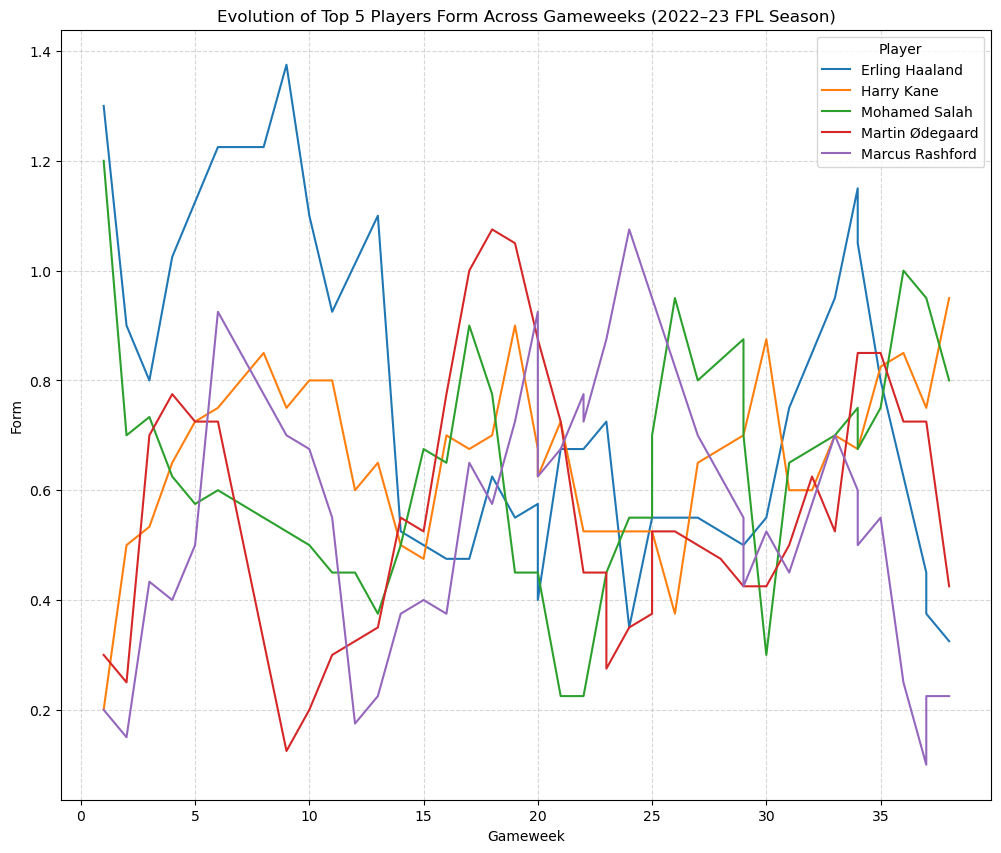

In [10]:
df_22 = df[df['season_x'] == '2022-23']
top5_players = (
    df_22.groupby('name')['total_points']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

df_top5 = df_22[df_22['name'].isin(top5_players)]

# Get total points across season
player_points = df_22.groupby('name')['total_points'].sum()

# Combine into one DataFrame
comparison = pd.DataFrame({
    'total_points': player_points
}).sort_values('total_points', ascending=False)

# Top 5 by total points
top_total = comparison.head(5)


print("Top 5 Players by Total Points:")
print(top_total)
top5_peak_form = (
    df_22.groupby('name')['form']
    .max()
    .sort_values(ascending=False)
    .head(5)
)

print("\nTop 5 Players by Form:")
print(top5_peak_form)
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(12, 10))

# Calculate top 5 players in form for each gameweek
top5_by_form = (
    df_22.groupby('GW')
    .apply(lambda g: g.sort_values('form', ascending=False)['name'].head(5).tolist())
)

# Plot the top 5 (by total points) players' form lines
for player in top5_players:
    player_data = df_top5[df_top5['name'] == player]
    plt.plot(player_data['GW'], player_data['form'], label=player)



# Final plot settings
plt.title('Evolution of Top 5 Players Form Across Gameweeks (2022–23 FPL Season)')
plt.xlabel('Gameweek')
plt.ylabel('Form')
plt.legend(title='Player')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


# 3 Predicitive model task


In [40]:
# Ensure correct ordering
df = df.sort_values(by=["name", "season_x", "GW"]).reset_index(drop=True)

# Shift total_points to create the "next GW" target per player per season
df["upcoming_total_points"] = df.groupby(["name", "season_x"])["total_points"].shift(-1)

# Drop last GW per player per season (no future target)
df = df.dropna(subset=["upcoming_total_points"])


In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math


# Separate features and target
X = df.drop(columns=['upcoming_total_points'])
y = df['upcoming_total_points']

In [ ]:
# import numpy as np
# # All numeric columns (you can tweak if some are actually categorical)
# numeric_features = [
#     'assists', 'bonus', 'clean_sheets', 'creativity',
#     'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
#     'influence', 'minutes', 'own_goals', 'penalties_missed',
#     'penalties_saved', 'red_cards', 'saves',
#     'team_a_score', 'team_h_score', 'threat', 'total_points', 'value',
#     'yellow_cards','opponent_team', 'form'
# ]

# # Categorical columns (non-numeric or text)
# categorical_features = [
#     'position',  'was_home'
# ]

# # Select only the features we need
# X = df[numeric_features + categorical_features]

# # One-hot encode categorical columns
# X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# X_scaled = X_scaled.astype(np.float32)  # make TensorFlow happy


We dropped the team names (team_x, opponent_team_name) as it didn't have a correlation with upcoming total points and there were other features that substituted for what they show like opponent_team would be a better alternative than their name

We started by using all other features, categorical like position and was_homw were one-hot encoded while the numerical features were standardized using Scaler.

Performance metrics MAE: 1.2076, MSE: 4.5968, RMSE: 2.1440, R2: 0.2891 
Using SHAP we found out Form had the highest impact on the total_upcoming_total 

We discarded features: feature_X , feature_Y .. as they showed negligible effect on the output and re-trained.



In [42]:
# modified the above cell so that we standardize the numeric features only and one hot encode the categorical features only

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Define feature sets
numeric_features = [
    'assists', 'bonus', 'clean_sheets', 'creativity',
    'element', 'fixture', 'goals_conceded', 'goals_scored', 'ict_index',
    'influence', 'minutes', 'own_goals', 'penalties_missed',
    'penalties_saved', 'red_cards', 'saves',
    'team_a_score', 'team_h_score', 'threat', 'total_points', 'value',
    'yellow_cards', 'opponent_team', 'form'
]

categorical_features = ['position', 'was_home']

# Select only the features we need
X = df[numeric_features + categorical_features]

# One-hot encode categorical columns (kept as 0/1)
X_cat = pd.get_dummies(X[categorical_features], drop_first=True)

# Scale numeric features only
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X[numeric_features])
X_num_scaled = pd.DataFrame(X_num_scaled, columns=numeric_features, index=X.index)

# Combine numeric and categorical back into one DataFrame
X_scaled = pd.concat([X_num_scaled, X_cat], axis=1)
feature_names = X_scaled.columns.tolist()  # <-- Capture actual column names

# Convert to float32 for TensorFlow
X_scaled = X_scaled.astype(np.float32)


In [43]:
X_scaled.columns

Index(['assists', 'bonus', 'clean_sheets', 'creativity', 'element', 'fixture',
       'goals_conceded', 'goals_scored', 'ict_index', 'influence', 'minutes',
       'own_goals', 'penalties_missed', 'penalties_saved', 'red_cards',
       'saves', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'value', 'yellow_cards', 'opponent_team', 'form', 'was_home',
       'position_FWD', 'position_GK', 'position_MID'],
      dtype='object')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X and y for correlation
df_corr = X_scaled.copy()
df_corr['upcoming_total_points'] = y.values

# Compute correlations
corr_matrix = df_corr.corr()

# Sort by correlation strength with target
corr_with_target = corr_matrix['upcoming_total_points'].sort_values(ascending=False)

print(corr_with_target)  # top 10 positive correlations
# print(corr_with_target)  # top 10 negative correlations


upcoming_total_points    1.000000
minutes                  0.477631
form                     0.453913
ict_index                0.404439
influence                0.374922
total_points             0.369327
creativity               0.314147
value                    0.312036
threat                   0.307411
goals_conceded           0.268984
clean_sheets             0.239556
bonus                    0.181705
goals_scored             0.177152
assists                  0.149468
saves                    0.124372
yellow_cards             0.117217
penalties_missed         0.035789
position_FWD             0.028742
position_MID             0.024059
own_goals                0.024055
penalties_saved          0.015186
team_h_score             0.011140
opponent_team            0.007652
team_a_score            -0.001725
was_home                -0.016425
red_cards               -0.017655
position_GK             -0.030658
fixture                 -0.032341
element                 -0.122935
Name: upcoming

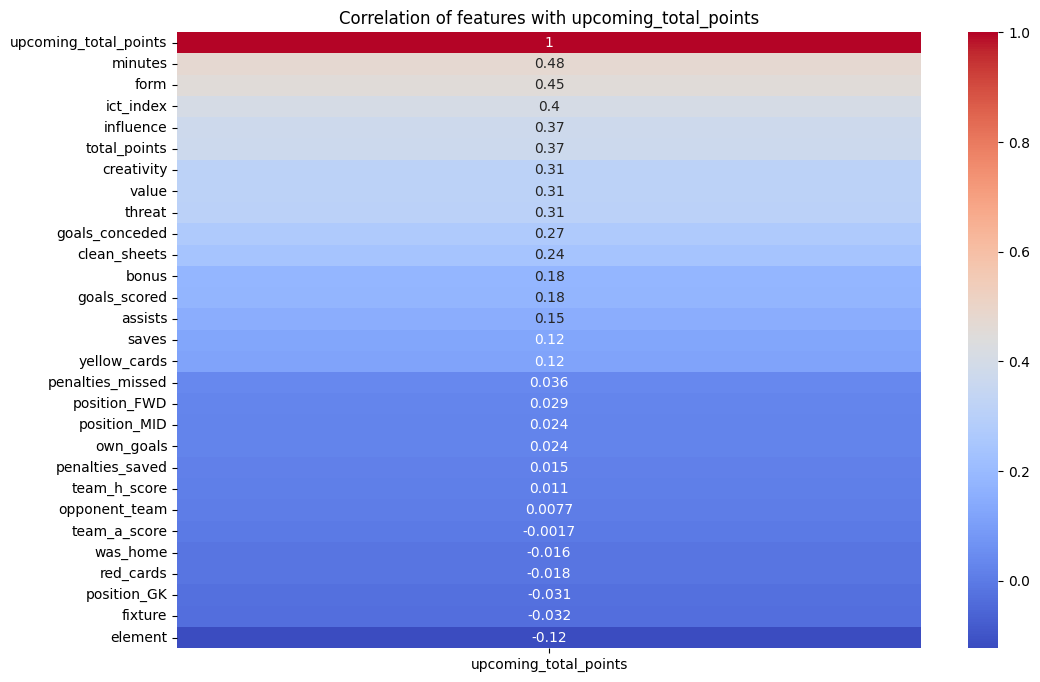

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['upcoming_total_points']].sort_values(by='upcoming_total_points', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlation of features with upcoming_total_points")
plt.show()


In [47]:
# build improved FFNN
model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.30),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.20),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')   # regression -> linear activation
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',            # or 'mae' if you care more about absolute error
    metrics=['mae', 'mse']
)

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6)
]

history = model.fit(
    X_train, y_train,
    validation_split=0.15,   # simple holdout inside train set (still group-safe because split done above)
    epochs=200,
    batch_size=256,
    callbacks=callbacks,
    verbose=2
)

# evaluation
preds = model.predict(X_test).squeeze()
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

Epoch 1/200
249/249 - 2s - 9ms/step - loss: 5.4290 - mae: 1.3804 - mse: 5.4290 - val_loss: 4.9711 - val_mae: 1.2874 - val_mse: 4.9711 - learning_rate: 1.0000e-03
Epoch 2/200
249/249 - 1s - 2ms/step - loss: 4.8504 - mae: 1.2792 - mse: 4.8504 - val_loss: 4.7938 - val_mae: 1.2863 - val_mse: 4.7938 - learning_rate: 1.0000e-03
Epoch 3/200
249/249 - 1s - 2ms/step - loss: 4.7759 - mae: 1.2635 - mse: 4.7759 - val_loss: 4.8013 - val_mae: 1.2686 - val_mse: 4.8013 - learning_rate: 1.0000e-03
Epoch 4/200
249/249 - 1s - 2ms/step - loss: 4.7404 - mae: 1.2517 - mse: 4.7404 - val_loss: 4.8204 - val_mae: 1.2660 - val_mse: 4.8204 - learning_rate: 1.0000e-03
Epoch 5/200
249/249 - 1s - 2ms/step - loss: 4.7204 - mae: 1.2442 - mse: 4.7204 - val_loss: 4.7961 - val_mae: 1.2668 - val_mse: 4.7961 - learning_rate: 1.0000e-03
Epoch 6/200
249/249 - 1s - 2ms/step - loss: 4.7030 - mae: 1.2425 - mse: 4.7030 - val_loss: 4.7748 - val_mae: 1.2313 - val_mse: 4.7748 - learning_rate: 1.0000e-03
Epoch 7/200
249/249 - 1s - 2

# 4 XAI SHAP

In [48]:
# import numpy as np

# # Ensure X_train and X_test are numeric NumPy arrays with float32 type
# X_train_np = X_train.to_numpy().astype(np.float32)
# X_test_np = X_test.to_numpy().astype(np.float32)

# background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]


In [51]:
# !pip install shap lime
import shap
import lime
import lime.lime_tabular
# Wrap your model prediction function
def predict_fn(X):
    return model.predict(X)
# Use Explainer -> finds the best XAI model to use for your model
# Use a small background (reference) set to speed up explanations
# If X_train_scaled is a DataFrame, shap.sample will preserve columns
background = shap.sample(X_train, 100, random_state=42)
# Let SHAP pick the best algorithm for your Keras model

explainer = shap.Explainer(model, background)
shap_values = explainer(X_test)


PermutationExplainer explainer: 18679it [27:27, 11.27it/s]                           


fixed error

C:\Users\SHANA\AppData\Local\Temp\ipykernel_5576\975359498.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, plot_type='bar')


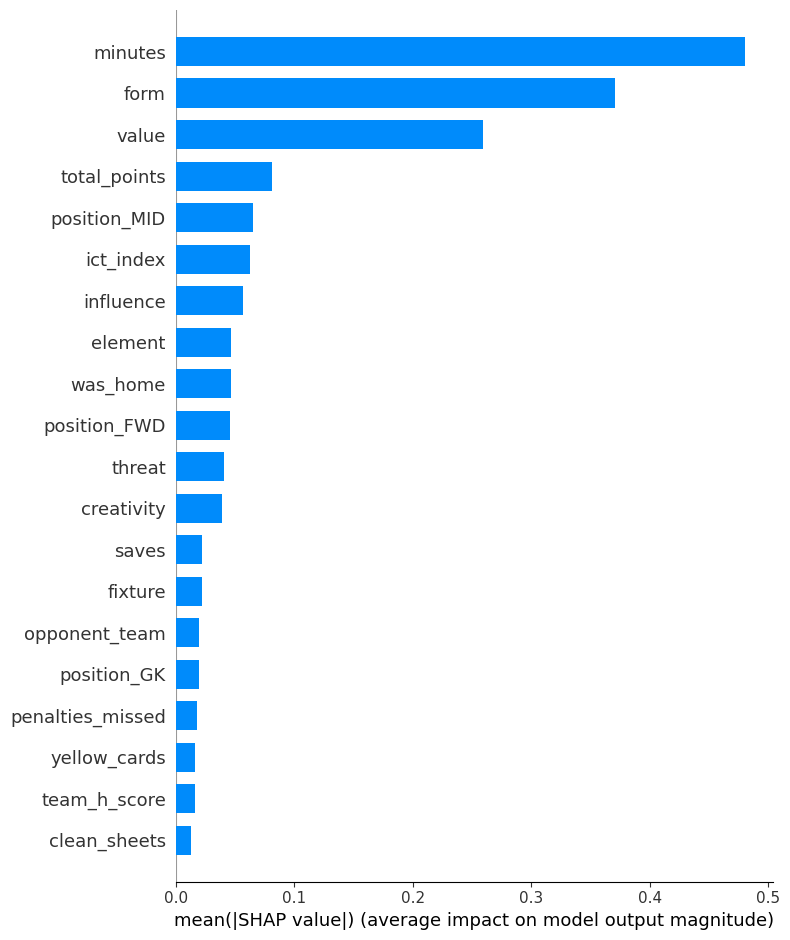

In [52]:
# Global summary
shap.summary_plot(shap_values.values, X_test, feature_names=feature_names, plot_type='bar')

# Local explanation
i = 0
# Easiest way with the new API
shap.plots.force(shap_values[i])

In [ ]:
# import pandas as pd
# import numpy as np
# import shap

# # Ensure all features are numeric
# X_test_numeric = X_test.select_dtypes(include=[np.number])

# # Or convert everything possible to numeric
# X_test_numeric = X_test.apply(pd.to_numeric, errors='coerce')

# # Replace NaNs (from coercion) if needed
# X_test_numeric = X_test_numeric.fillna(0)

# # Convert to numpy array
# X_test_np = X_test_numeric.to_numpy()

# # For background, pick a sample from training
# background = X_test_np[np.random.choice(X_test_np.shape[0], 100, replace=False)]

# # Now re-run SHAP
# explainer = shap.Explainer(model, background)
# shap_values = explainer(X_test_np)

# shap.summary_plot(shap_values.values, X_test_np, feature_names=X_test_numeric.columns, plot_type='bar')


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''